# Investigate the Vgsc gene model under different transcripts

In [1]:
%run setup.ipynb

In [2]:
phase2_ar1.load_geneset_agamp44(attributes=['ID', 'Parent'])
geneset_agamp44 = geneset_to_pandas(phase2_ar1.geneset_agamp44)
geneset_agamp44.head()

In [5]:
geneset_agamp44.type.value_counts()

exon               67318
CDS                63196
mRNA               14891
gene               13025
five_prime_UTR     10938
three_prime_UTR     7611
tRNA_gene            463
tRNA                 463
miRNA_gene           162
miRNA                162
rRNA_gene             78
rRNA                  78
snRNA_gene            38
snRNA                 38
pseudogene            20
snoRNA_gene           12
snoRNA                12
RNA                   10
misc_RNA              10
tRNA_pseudogene        9
pseudogenic_tRN        9
chromosome             8
SRP_RNA                3
RNase_P_RNA            1
Name: type, dtype: int64

In [6]:
region_vgsc = '2L', 2358158, 2431617

In [7]:
region_vgsc[2] - region_vgsc[1] + 1

73460

In [12]:
geneset_agamp44_vgsc = geneset_agamp44.query("(seqid == %r) & (start >= %s) & (end <= %s)" % region_vgsc)
geneset_agamp44_vgsc.head()

,seqid,source,type,start,end,score,strand,phase,ID,Parent
665,2L,VectorBase,CDS,2358158,2358304,-1,+,0,AGAP004707-PA,AGAP004707-RA
666,2L,VectorBase,CDS,2358158,2358304,-1,+,0,AGAP004707-PB,AGAP004707-RB
667,2L,VectorBase,CDS,2358158,2358304,-1,+,0,AGAP004707-PC,AGAP004707-RC
668,2L,VectorBase,exon,2358158,2358304,-1,+,-1,.,AGAP004707-RA
669,2L,VectorBase,exon,2358158,2358304,-1,+,-1,.,AGAP004707-RB


In [13]:
geneset_agamp44_vgsc.type.value_counts()

CDS     93
exon    93
mRNA     3
gene     1
Name: type, dtype: int64

In [14]:
def plot_transcripts(geneset, chrom, start, stop, height=.5, label_transcripts=True, label_exons=False, label_exon_size=False,
                     label_codons=False, highlight_exons=None, highlight_color='pink', ax=None):
    """Plot all transcripts for all genes overlapping a given region."""

    if ax is None:
        fig, ax = plt.subplots(figsize=(15, 2))
        sns.despine(ax=ax, left=True, offset=5)

    # find genes overlapping the given region 
    genes = geneset.query("(type == 'gene') and (seqid == %r) and (end >= %s) and (start <= %s)" % (chrom, start, stop)).sort_values('start')

    # iterate over genes
    for _, gene in genes.iterrows():

        # find child transcripts
        transcripts = geneset.query("(type == 'mRNA') and (Parent == %r)" % gene.ID).sort_values('ID')

        # iterate over transcripts
        for i, (_, transcript) in enumerate(transcripts.iterrows()):
            
            # coordinates for plotting the transcript
            if transcript.strand == '+':
                y = i
            else:
                y = -i - 1

            # annotate with transcript ID
            text_y = y + height + (height / 10)
            if label_transcripts == 'right':
                text_x = min(stop, transcript.end)
                ha = 'right'
            else:
                text_x = max(start, transcript.start)
                ha = 'left'
            if label_transcripts:
                if transcript.strand == '+':
                    text = '%s >' % transcript.ID
                else:
                    text = '< %s' % transcript.ID
                ax.text(text_x, text_y, text, ha=ha, va='bottom')
            
            # find child exons
            exons = geneset.query("type == 'exon' and Parent == %r" % transcript.ID).sort_values('start')
            
            # iterate over exons to plot introns
            last_exon = None
            for i, (_, exon) in enumerate(exons.iterrows()):
                x = exon.start
                width = exon.end - x

                # plot intron
                if last_exon is not None:
                    ax.plot([last_exon.end, (last_exon.end + exon.start) / 2, exon.start], [y + height / 2, y + height / 1.5, y + height / 2], 'k-')
                last_exon = exon
                
                # exon number
                n = i + 1 if exon.strand == '+' else len(exons) - i
                
                # label exons
                if label_exons and exon.end > start and exon.start < stop:
                    text_x = (exon.start + exon.end) / 2
                    ha = 'center'
                    if text_x < start:
                        text_x = start
                        ha = 'left'
                    elif text_x > stop:
                        text_x = stop
                        ha = 'right'
                    s = str(n)
                    if label_exon_size:
                        s += ' (%s)' % (exon.end - exon.start + 1)
                    if label_exons == 'center':
                        ax.text(text_x, y + height / 2, s, ha=ha, va='center', color='w', zorder=20, fontweight='bold')
                    else:
                        ax.text(text_x, text_y, s, ha=ha, va='bottom', color='k', zorder=20)
                
                # highlight exons
                if highlight_exons and (transcript.ID, n) in highlight_exons:
                    patch = plt.Rectangle((x, y), width, height, color=highlight_color, alpha=1, zorder=10)
                    ax.add_patch(patch)

            # find child CDSs
            cdss = geneset.query("type == 'CDS' and Parent == %r" % transcript.ID)
            if transcript.strand == '+':
                cdss = cdss.sort_values('start', ascending=True)
            else:
                cdss = cdss.sort_values('end', ascending=False)
            # keep track of CDS position
            cds_pos = 0
            for _, cds in cdss.iterrows():
                x = cds.start
                width = cds.end - x
                patch = plt.Rectangle((x, y), width, height, color='k')
                ax.add_patch(patch)
                if label_codons:
                    # report 1-based numbers
                    s = '%s (%s)' % ((cds_pos // 3) + 1, cds_pos + 1)
                    if transcript.strand == '+':
                        text_x = x
                        ha = 'left'
                    else:
                        text_x = x + width
                        ha = 'right'
                    if text_x > start and text_x < stop:
                        ax.text(text_x, text_y, s, ha=ha, va='bottom')
                # accumulate CDS positions
                cds_pos += width + 1  # N.B., GFF coords are 1-based end-inclusive

            # find child UTRs
            utrs = geneset.query("(type == 'three_prime_UTR' or type == 'five_prime_UTR') and Parent == %r" % transcript.ID).sort_values('start')
            for _, utr in utrs.iterrows():
                x = utr.start
                width = utr.end - x
                utr_height = height * .8
                utr_y = y + (height - utr_height) / 2
                patch = plt.Rectangle((x, utr_y), width, utr_height, facecolor='#cccccc', edgecolor='k')
                ax.add_patch(patch)

    ax.set_yticks([])
    ax.set_xlim(start, stop)
    ax.set_xticklabels([humanize.intcomma(int(x)) for x in ax.get_xticks()])
#     ax.axhline(0 - (height / 2), color='k', linestyle='--')
    ax.set_xlabel('Chromosome %s position (bp)' % chrom)
    ax.autoscale(axis='y', tight=True)
    

In [15]:
def transcript_length_stats(geneset, gene_id):
    
    # N.B., GFF coordinates are 1-based end-inclusive
    
    # find child transcripts
    transcripts = geneset.query("(type == 'mRNA') and (Parent == %r)" % gene_id).sort_values('ID')

    # iterate over transcripts
    for i, (_, transcript) in enumerate(transcripts.iterrows()):
        print(transcript.ID)
        
        # compute total span
        print('total span: %s bp' % intcomma(transcript.end - transcript.start + 1))

        # compute total exon length
        exons = geneset.query("type == 'exon' and Parent == %r" % transcript.ID)
        print('number of exons: %s' % len(exons))
        total_exon_length = sum([(f.end - f.start + 1) for _, f in exons.iterrows()])
        print('total exon length: %s bp' % total_exon_length)
        
        # compute total CDS length
        cdss = geneset.query("type == 'CDS' and Parent == %r" % transcript.ID)
        total_cds_length = sum([(f.end - f.start + 1) for _, f in cdss.iterrows()])
        print('total CDS length: %s bp (%s codons)' % (total_cds_length, total_cds_length / 3))
        
        # compute total UTR length
        utrs = geneset.query("(type == 'three_prime_UTR' or type == 'five_prime_UTR') and Parent == %r" % transcript.ID)
        total_utr_length = sum([(f.end - f.start + 1) for _, f in utrs.iterrows()])
        print('total UTR length: %s bp' % total_utr_length)
        
        assert total_exon_length == total_cds_length + total_utr_length, "WEIRDNESS ALERT"


In [16]:
transcript_length_stats(geneset_agamp44, 'AGAP004707')

AGAP004707-RA
total span: 73,460 bp
number of exons: 31
total exon length: 6357 bp
total CDS length: 6357 bp (2119.0 codons)
total UTR length: 0 bp
AGAP004707-RB
total span: 73,460 bp
number of exons: 31
total exon length: 6279 bp
total CDS length: 6279 bp (2093.0 codons)
total UTR length: 0 bp
AGAP004707-RC
total span: 73,460 bp
number of exons: 31
total exon length: 6279 bp
total CDS length: 6279 bp (2093.0 codons)
total UTR length: 0 bp


## Examine transcript differences for AgamP4.4 transcripts

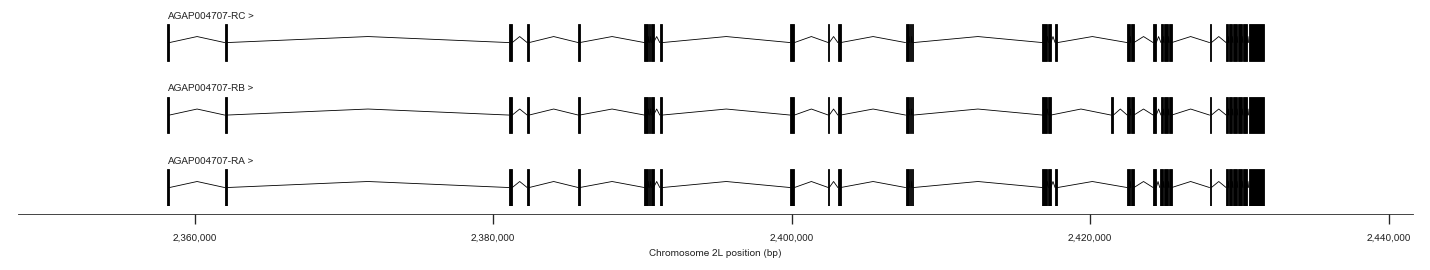

In [17]:
chrom, start, stop = region_vgsc
plot_transcripts(geneset_agamp44, chrom, start-10000, stop+10000)

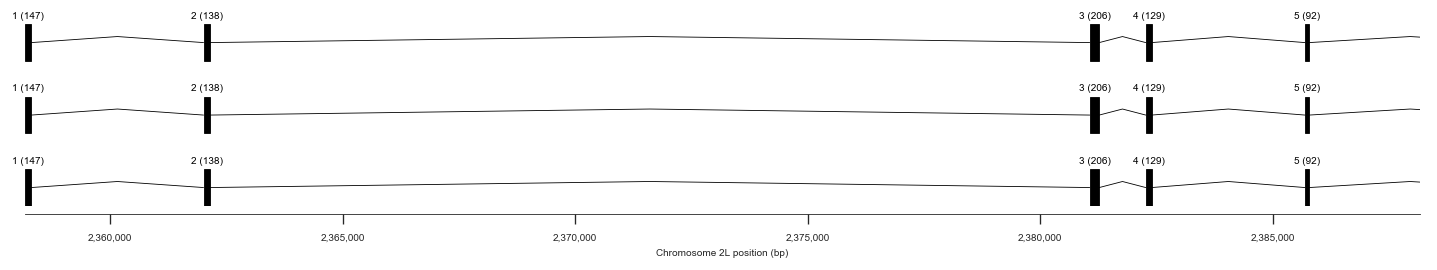

In [18]:
chrom, start, stop = region_vgsc
plot_transcripts(geneset_agamp44, chrom, start, start + 30000, label_exons=True, label_transcripts=False, label_exon_size=True)

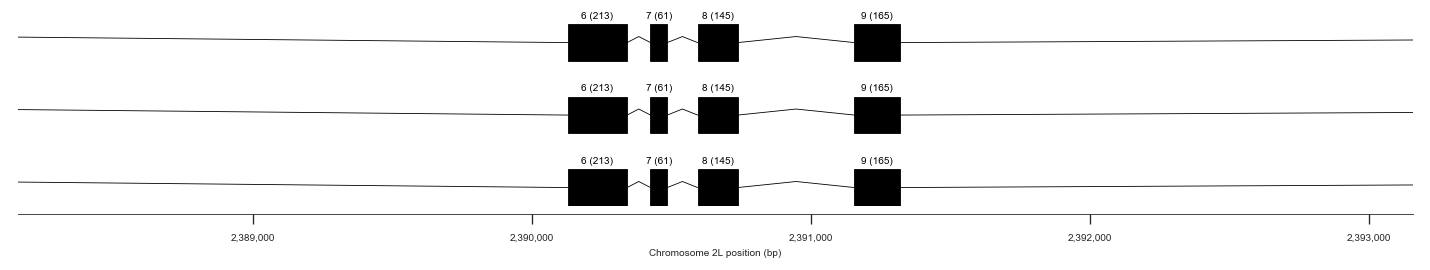

In [19]:
chrom, start, stop = region_vgsc
plot_transcripts(geneset_agamp44, chrom, start + 30000, start + 35000, label_exons=True, label_transcripts=False, label_exon_size=True)

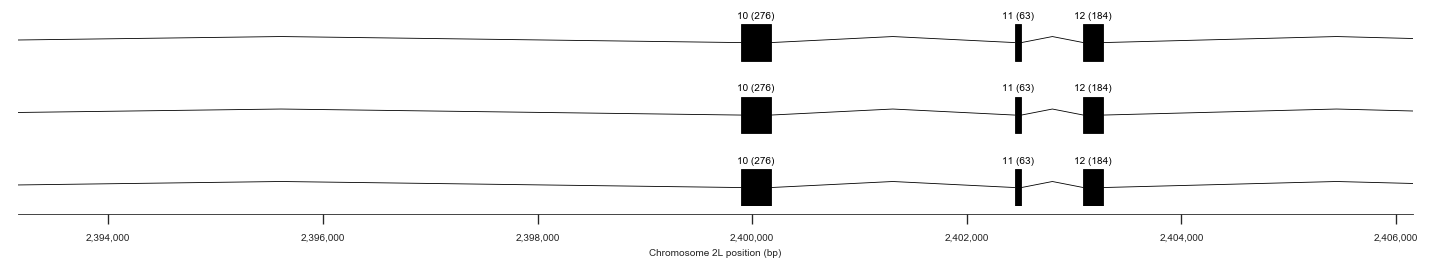

In [20]:
chrom, start, stop = region_vgsc
plot_transcripts(geneset_agamp44, chrom, start + 35000, start + 48000, label_exons=True, label_transcripts=False, label_exon_size=True)

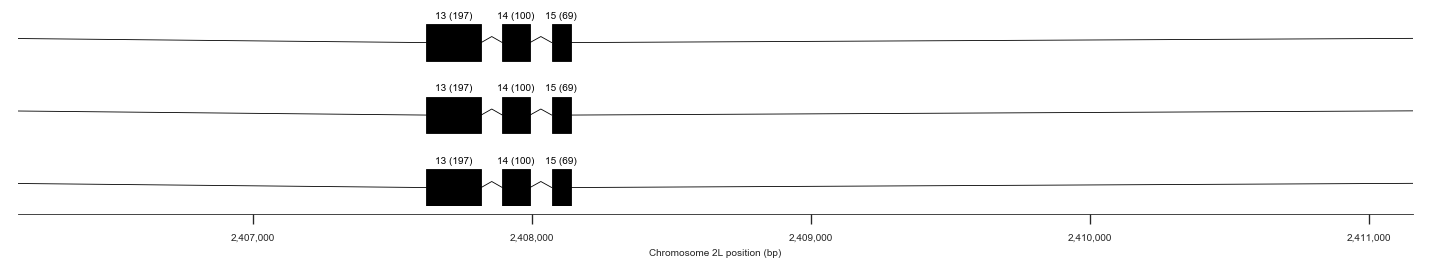

In [21]:
chrom, start, stop = region_vgsc
plot_transcripts(geneset_agamp44, chrom, start + 48000, start + 53000, label_exons=True, label_transcripts=False, label_exon_size=True)

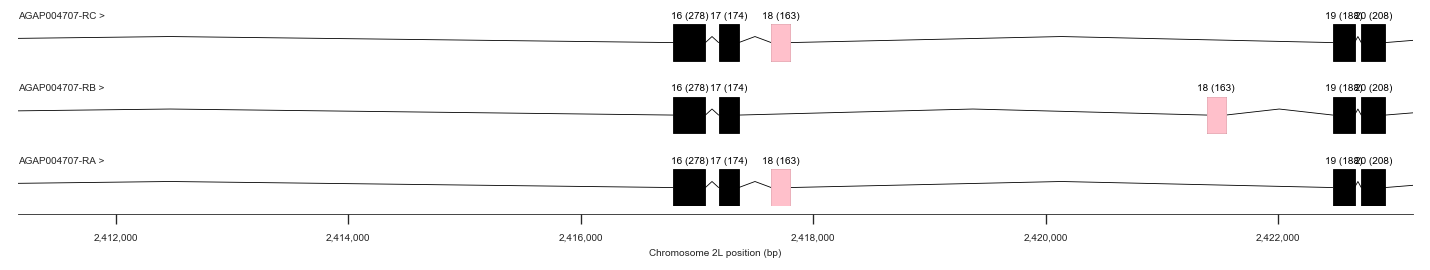

In [22]:
chrom, start, stop = region_vgsc
plot_transcripts(geneset_agamp44, chrom, start + 53000, start + 65000, label_exons=True, label_transcripts=True, label_exon_size=True, 
                 highlight_exons=[('AGAP004707-RA', 18), ('AGAP004707-RB', 18), ('AGAP004707-RC', 18)])

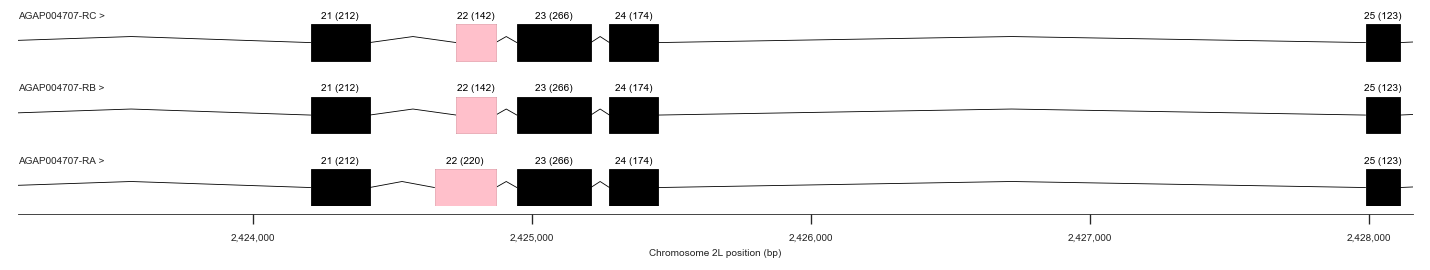

In [23]:
chrom, start, stop = region_vgsc
plot_transcripts(geneset_agamp44, chrom, start + 65000, start + 70000, label_exons=True, label_transcripts=True, label_exon_size=True, 
                 highlight_exons=[('AGAP004707-RA', 22), ('AGAP004707-RB', 22), ('AGAP004707-RC', 22)])

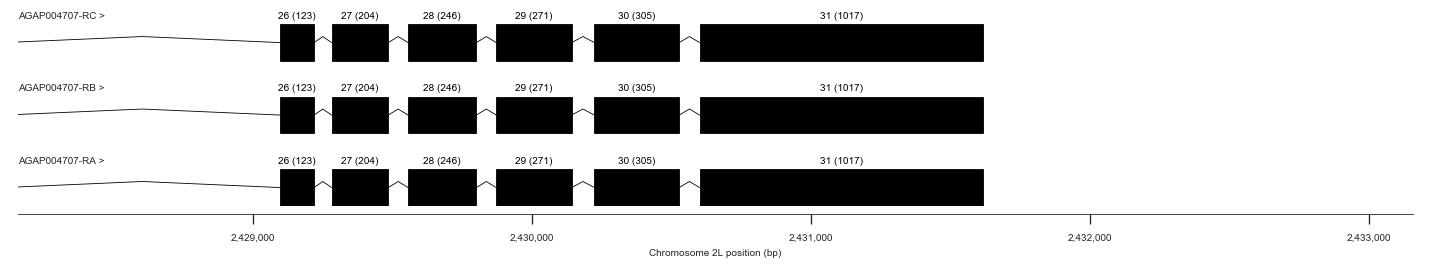

In [24]:
chrom, start, stop = region_vgsc
plot_transcripts(geneset_agamp44, chrom, start + 70000, start + 75000, label_exons=True, label_transcripts=True, label_exon_size=True)

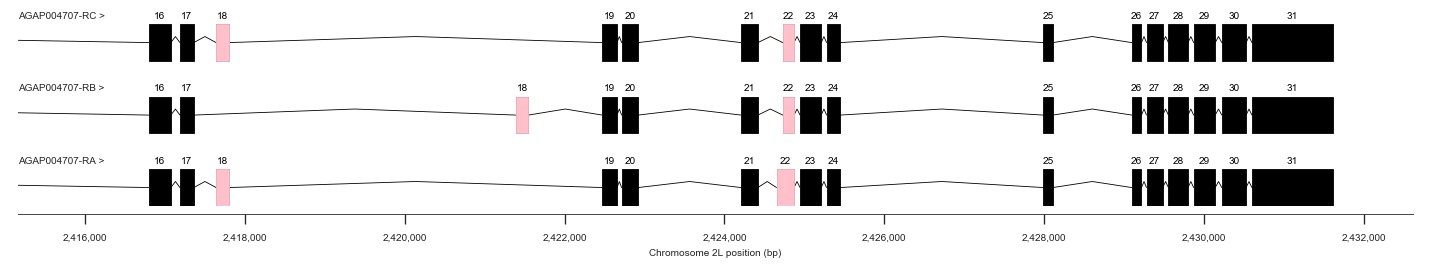

In [25]:
chrom, start, stop = region_vgsc
plot_transcripts(geneset_agamp44, chrom, start+57000, stop+1000, label_exons=True, label_transcripts=True,
                 highlight_exons=[('AGAP004707-RA', 18), ('AGAP004707-RB', 18), ('AGAP004707-RC', 18), ('AGAP004707-RA', 22), ('AGAP004707-RB', 22), ('AGAP004707-RC', 22)])

## Examine AgamP4.4 codon positions

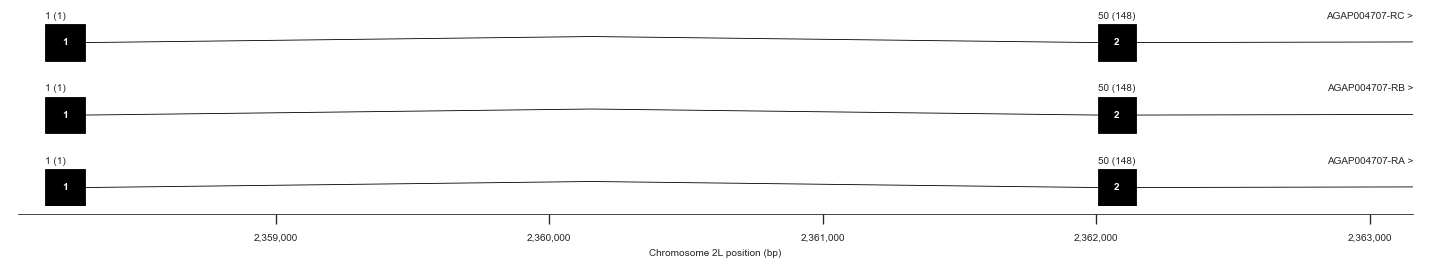

In [26]:
chrom, start, stop = region_vgsc
plot_transcripts(geneset_agamp44, chrom, start-100, start + 5000, label_transcripts='right', label_codons=True, label_exons='center')

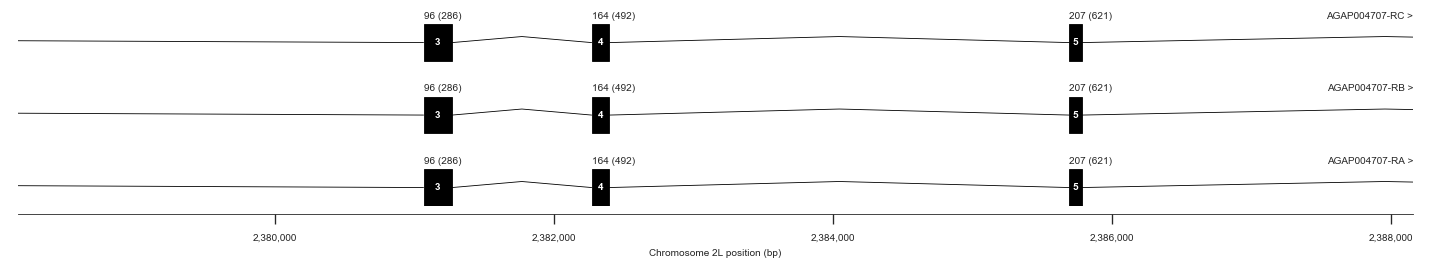

In [27]:
chrom, start, stop = region_vgsc
plot_transcripts(geneset_agamp44, chrom, start+20000, start + 30000, label_transcripts='right', label_codons=True, label_exons='center')

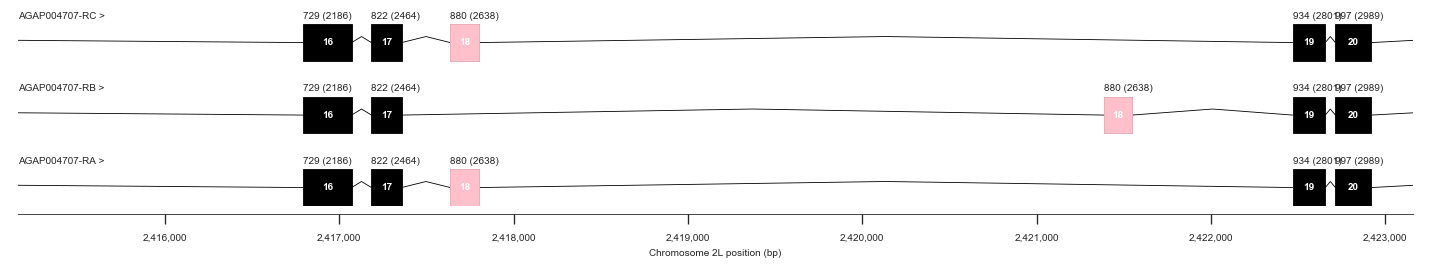

In [28]:
chrom, start, stop = region_vgsc
plot_transcripts(geneset_agamp44, chrom, start + 57000, start + 65000, label_transcripts=True, label_codons=True, label_exons='center',
                 highlight_exons=[('AGAP004707-RA', 18), ('AGAP004707-RB', 18), ('AGAP004707-RC', 18)])

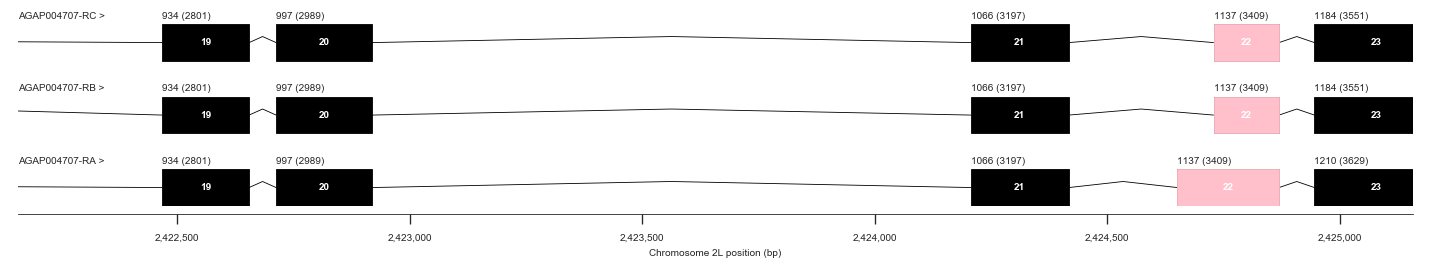

In [29]:
chrom, start, stop = region_vgsc
plot_transcripts(geneset_agamp44, chrom, start + 64000, start + 67000, label_transcripts=True, label_codons=True, label_exons='center',
                 highlight_exons=[('AGAP004707-RA', 18), ('AGAP004707-RB', 18), ('AGAP004707-RC', 18), ('AGAP004707-RA', 22), ('AGAP004707-RB', 22), ('AGAP004707-RC', 22)])

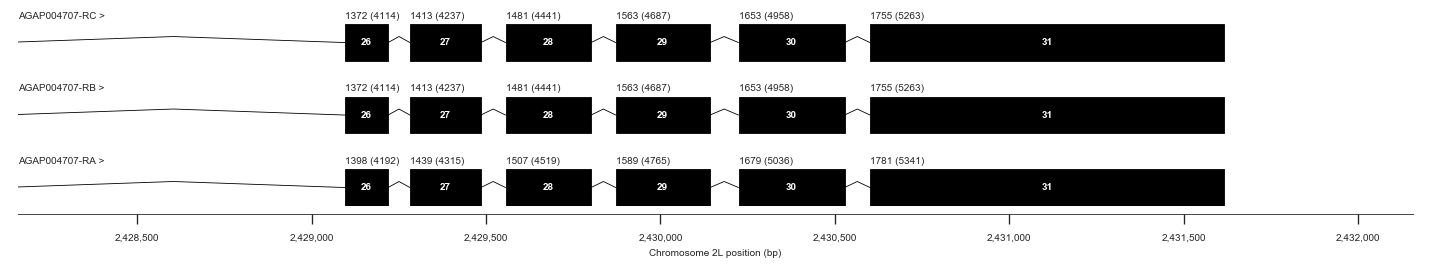

In [30]:
chrom, start, stop = region_vgsc
plot_transcripts(geneset_agamp44, chrom, start + 70000, start + 74000, label_transcripts=True, label_codons=True, label_exons='center',
                 highlight_exons=[('AGAP004707-RA', 18), ('AGAP004707-RB', 18), ('AGAP004707-RC', 18), ('AGAP004707-RA', 22), ('AGAP004707-RB', 22), ('AGAP004707-RC', 22)])

## Testing

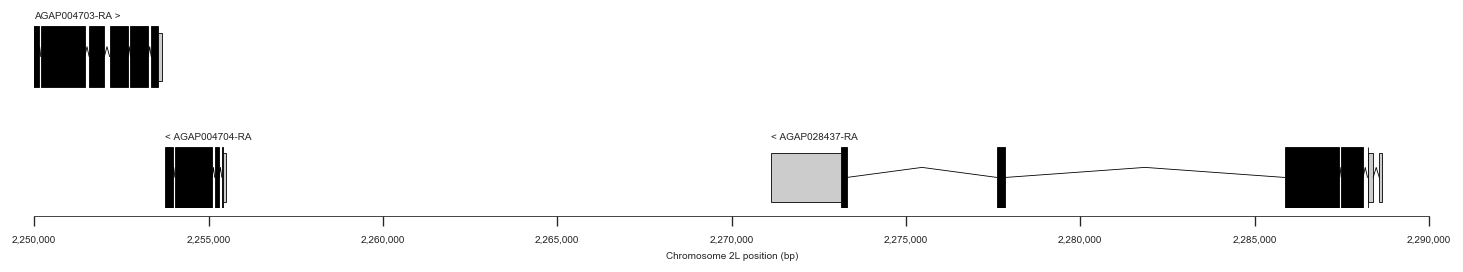

In [31]:
plot_transcripts(geneset_agamp44, chrom, 2250000, 2290000)

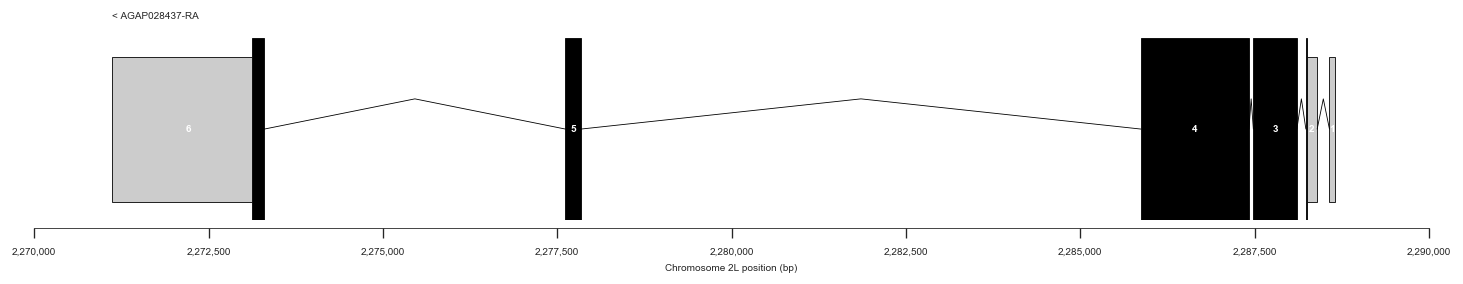

In [32]:
plot_transcripts(geneset_agamp44, chrom, 2270000, 2290000, label_exons='center')

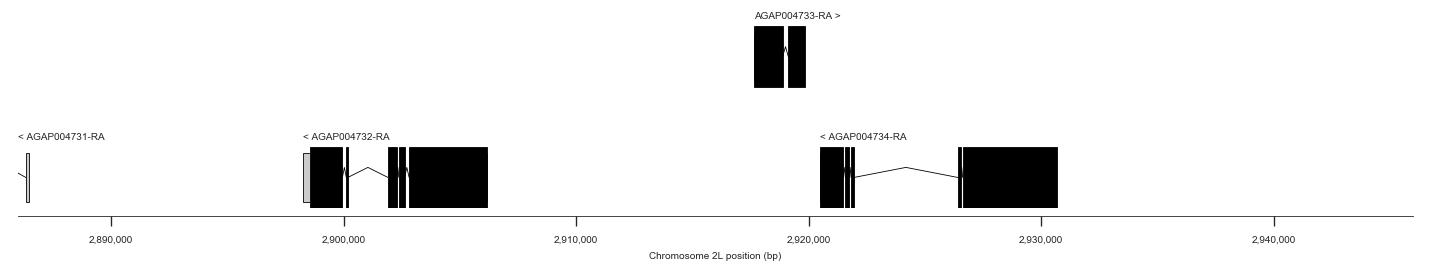

In [33]:
plot_transcripts(geneset_agamp44, chrom, 2886000, 2946000)